## Feature Engineering and Principal Component Analysis on S&P 500 Fundamentals Data

Feature engineering involves transforming potential predictor variables into features that make them best-suited to work within the model to explain variance in the outcome of interest. Principal Component Analysis (PCA), on the other hand, is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables. At a conceptual level, PCA works by identifying sets of variables that share variance, and creating a component to represent that variance.

### A. Explore the Data

After defining the research question, the next step towards building a model is to get to know the individual variables through inspection of the data file itself, visualizations, and univariate and bivariate descriptive statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Open S&P 500 fundamentals data and determine variables' types.
df = pd.read_csv('fundamentals.csv')
df.dtypes

Unnamed: 0                                               int64
Ticker Symbol                                           object
Period Ending                                           object
Accounts Payable                                       float64
Accounts Receivable                                    float64
Add'l income/expense items                             float64
After Tax ROE                                          float64
Capital Expenditures                                   float64
Capital Surplus                                        float64
Cash Ratio                                             float64
Cash and Cash Equivalents                              float64
Changes in Inventories                                 float64
Common Stocks                                          float64
Cost of Revenue                                        float64
Current Ratio                                          float64
Deferred Asset Charges                                 

In [3]:
# Convert Period Ending column to date format to create year column.
df['Period Ending'] = pd.to_datetime(df['Period Ending'])
df['year'] = df['Period Ending'].dt.year

# Show number of stocks by year.
df.groupby('year').count()['Ticker Symbol']

year
2003      1
2004      1
2006      1
2007      1
2012    236
2013    439
2014    436
2015    445
2016    220
2017      1
Name: Ticker Symbol, dtype: int64

In [4]:
# Create a subset to explore based on most complete and recent yearly data and variables of interest.
df_sub = df.loc[(df['year']==2015)|(df['year']==2014), ['Ticker Symbol', 'Capital Expenditures', 'Earnings Before Interest and Tax', 'Gross Profit', 'Profit Margin', 'Total Assets', 'Total Liabilities', 'year']]
df_sub.head()

,Ticker Symbol,Capital Expenditures,Earnings Before Interest and Tax,Gross Profit,Profit Margin,Total Assets,Total Liabilities,year
2,AAL,-5.311000e+09,4.099000e+09,2.703000e+10,7.0,4.322500e+10,4.120400e+10,2014
3,AAL,-6.151000e+09,5.496000e+09,2.989400e+10,19.0,4.841500e+10,4.278000e+10,2015
6,AAP,-2.284460e+08,8.548020e+08,4.453613e+09,5.0,7.962358e+09,5.959446e+09,2015
9,AAPL,-9.571000e+09,5.348300e+10,7.053700e+10,22.0,2.318390e+11,1.202920e+11,2014
10,AAPL,-1.124700e+10,7.251500e+10,9.362600e+10,23.0,2.903450e+11,1.709900e+11,2015


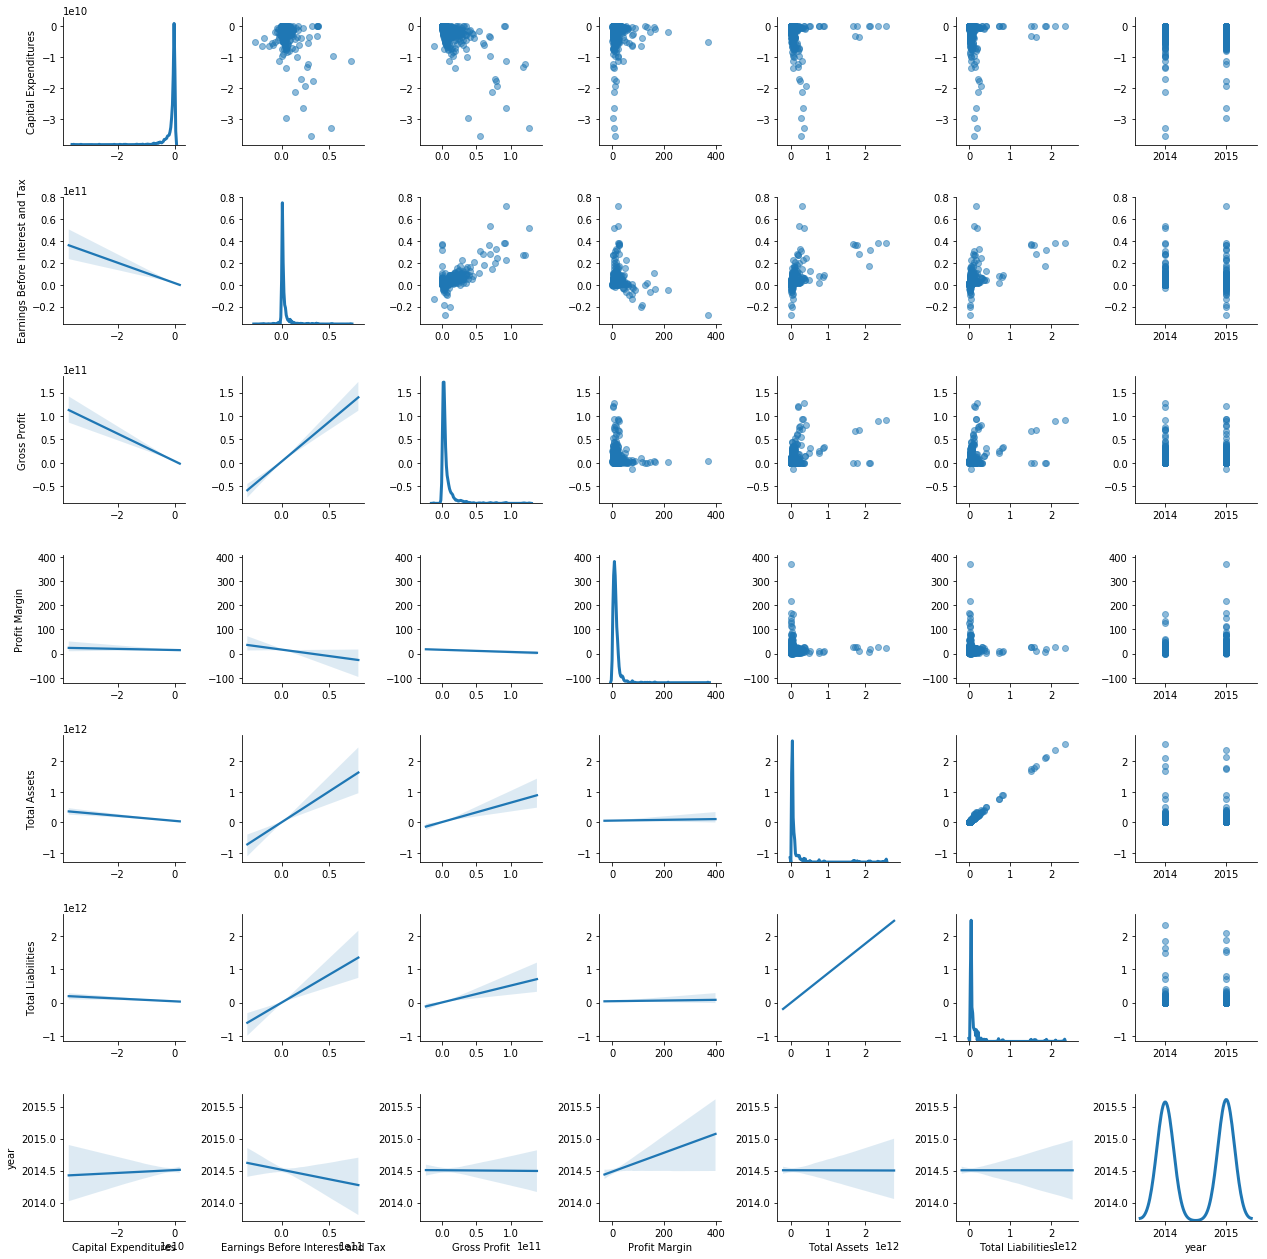

In [5]:
# Show bivariate distributions of the variables to determine relationships.
g = sns.PairGrid(df_sub.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

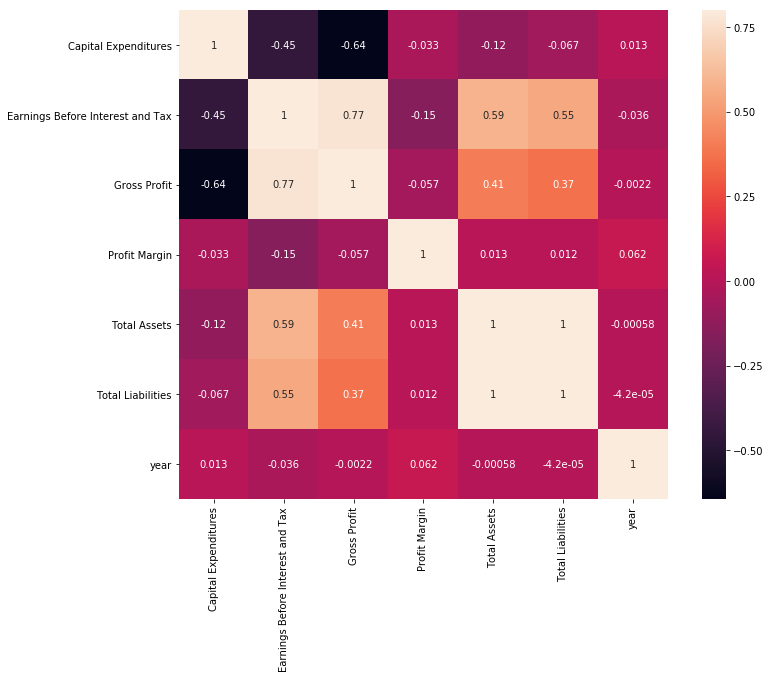

In [6]:
# Further explore variables' correlation with a correlation matrix.
corrmat = df_sub.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

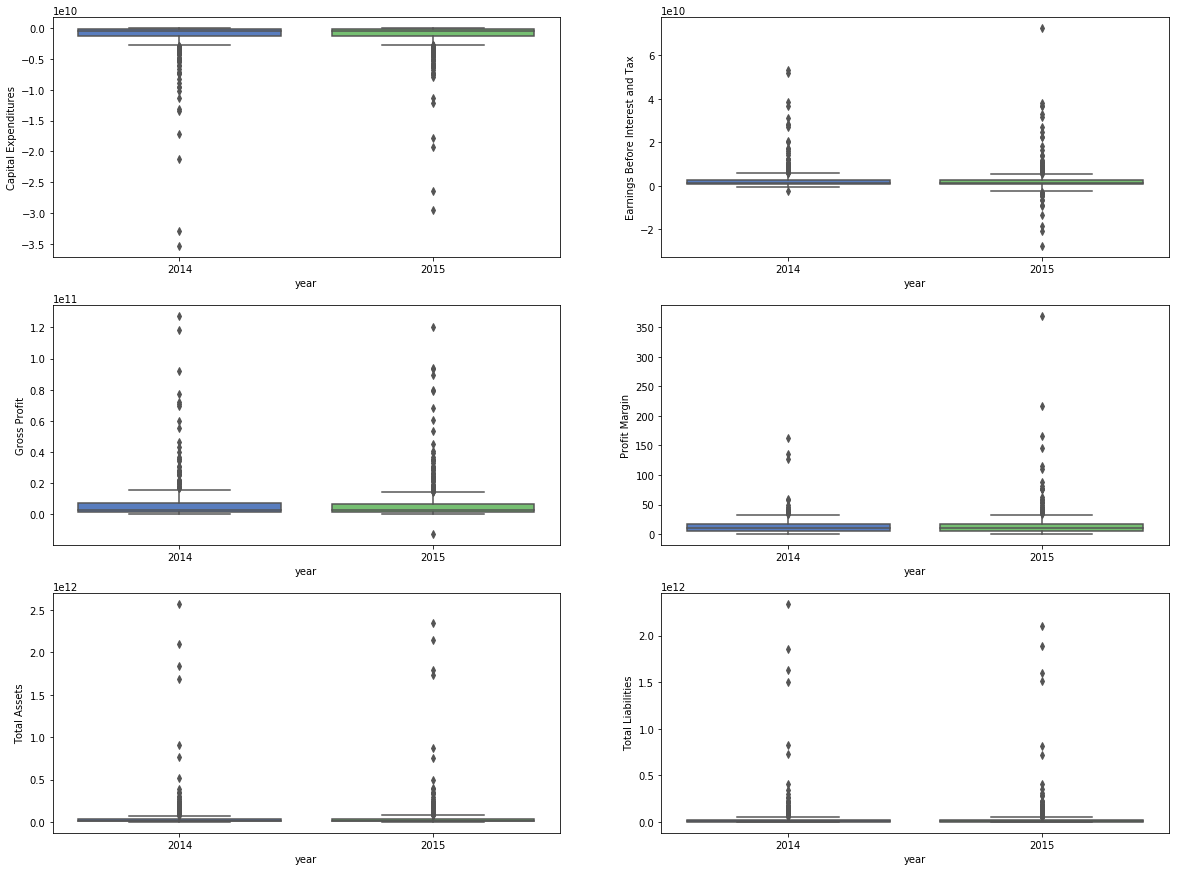

In [7]:
# Create boxplots to compare the six variables' distributions.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

cap = sns.boxplot(x='year', y='Capital Expenditures', palette='muted', data=df_sub, ax=ax1)
ebit = sns.boxplot(x='year', y='Earnings Before Interest and Tax', palette='muted', data=df_sub, ax=ax2)
gp = sns.boxplot(x='year', y='Gross Profit', palette='muted', data=df_sub, ax=ax3)
pm = sns.boxplot(x='year', y='Profit Margin', palette='muted', data=df_sub, ax=ax4)
ta = sns.boxplot(x='year', y='Total Assets', palette='muted', data=df_sub, ax=ax5)
tl = sns.boxplot(x='year', y='Total Liabilities', palette='muted', data=df_sub, ax=ax6)
plt.show()

In [8]:
# Conduct a t-test to determine significance between 2014 and 2015 data.
for col in df_sub.loc[:,'Capital Expenditures':'Total Liabilities'].columns:
    print(col)
    print(stats.ttest_ind(df_sub[df_sub['year'] == 2014][col].dropna(), df_sub[df_sub['year'] == 2015][col].dropna()))

Capital Expenditures
Ttest_indResult(statistic=-0.38551449681274358, pvalue=0.69994954326524628)
Earnings Before Interest and Tax
Ttest_indResult(statistic=1.0652328204279902, pvalue=0.28706309908892941)
Gross Profit
Ttest_indResult(statistic=0.065629108959937621, pvalue=0.94768803649559397)
Profit Margin
Ttest_indResult(statistic=-1.8329795698615532, pvalue=0.067143683970031481)
Total Assets
Ttest_indResult(statistic=0.017330225568227078, pvalue=0.98617710547643866)
Total Liabilities
Ttest_indResult(statistic=0.0012308591744690704, pvalue=0.99901819599499164)


No significance observed between the two years.

### B. Feature Engineering

There are very few limits with feature engineering. Anything that will highlight a particular feature within the dataset can be tried. Some of these techniques involve:

#### 1. Creating categorical variables.

Most models will only run on numerical data. To get the information from a categorical variable with x levels, create x-1 numerical features, each of which is coded 1 or 0. It's also possible to create an indicator that gathers together categories that are related.

In [9]:
# Create a dataframe to hold the features.
features = pd.get_dummies(df['year'])

# Create a "recent" feature based on the most recent yearly data.
features['Recent'] = np.where((df['year'].isin([2014, 2015, 2016])), 1, 0)
print(pd.crosstab(features['Recent'], df['year']))

year    2003  2004  2006  2007  2012  2013  2014  2015  2016  2017
Recent                                                            
0          1     1     1     1   236   439     0     0     0     1
1          0     0     0     0     0     0   436   445   220     0


#### 2. Changing variable types.

Take a continuous variable and make it categorical.

In [10]:
# Create a "high margin" feature based on profit margin.
features['high_margin'] = np.where(df['Profit Margin']>=10, 1, 0)
print(df['Profit Margin'].groupby(features['high_margin']).describe())

             count       mean        std   min   25%   50%   75%    max
high_margin                                                            
0            799.0   5.392991   2.516263   0.0   3.0   6.0   8.0    9.0
1            982.0  20.926680  21.117909  10.0  12.0  16.0  22.0  369.0


#### 3. Combining two or more highly-correlated variables.

Many models assume that features are correlated with the outcome, but uncorrelated with each other. Two highly-correlated variables can be averaged to create a feature, or one can be dropped, for example.

In [11]:
# Find the highest correlated variables to gross profit.
corrmat2 = df.corr()
print(corrmat2['Gross Profit'][(corrmat2['Gross Profit']>.8) & (corrmat2['Gross Profit']!=1)])

Earnings Before Interest and Tax    0.805251
Operating Income                    0.842656
Total Revenue                       0.817326
Name: Gross Profit, dtype: float64


In [12]:
# Normalize these highly correlated variables and create an "earnings" feature.
means = df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']].mean(axis=0)
stds = df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']].std(axis=0)
features['earnings'] = ((df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']] - means) / stds).mean(axis=1)
plotdf = df.loc[:, ['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']]
plotdf['earnings'] = features['earnings'] 

# Check how well the composite correlates with each of the individual variables.
corrmat3 = plotdf.corr()
print(corrmat3)

                                  Gross Profit  \
Gross Profit                          1.000000   
Earnings Before Interest and Tax      0.805251   
Operating Income                      0.842656   
Total Revenue                         0.817326   
earnings                              0.942889   

                                  Earnings Before Interest and Tax  \
Gross Profit                                              0.805251   
Earnings Before Interest and Tax                          1.000000   
Operating Income                                          0.909479   
Total Revenue                                             0.700922   
earnings                                                  0.929398   

                                  Operating Income  Total Revenue  earnings  
Gross Profit                              0.842656       0.817326  0.942889  
Earnings Before Interest and Tax          0.909479       0.700922  0.929398  
Operating Income                          1.

The earnings feature is highly correlated to gross profit, earnings before interest and tax, operating income, and total revenue; thus, it can represent these variables.

#### 4. Dealing with non-normality.

If normality is a model-assumption (and it often is), then non-normal variables can sometimes be transformed into normally-distributed features using transformations such as taking the square root, the inverse, or the log of the variable.

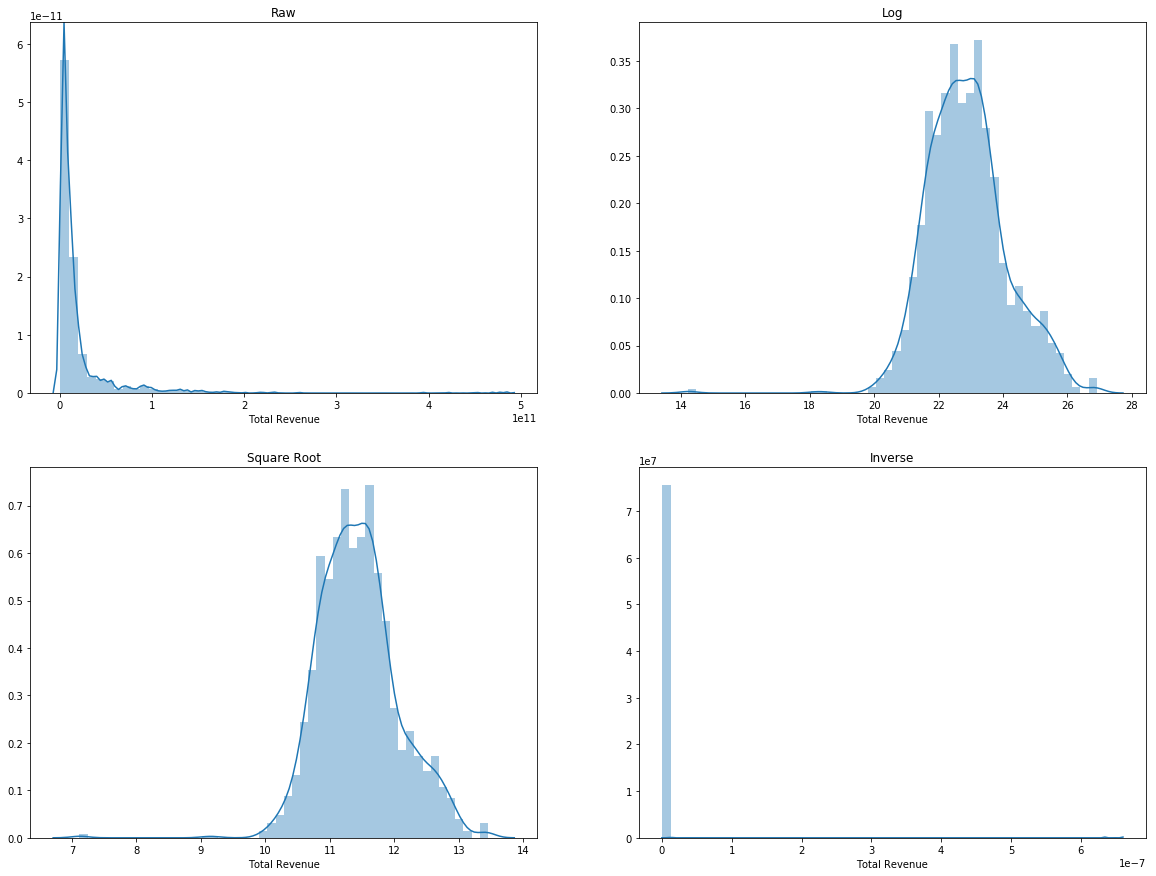

In [13]:
# Create variable transformations on total revenue.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

tr1=sns.distplot(df['Total Revenue'].dropna(), hist=True, ax=ax1)
ax1.set_title('Raw')
tr2=sns.distplot(np.log(df['Total Revenue'].dropna()), hist=True, ax=ax2)
ax2.set_title('Log')
tr3=sns.distplot(np.log(np.sqrt(df['Total Revenue'].dropna())), hist=True, ax=ax3)
ax3.set_title('Square Root')
tr4=sns.distplot(1/df['Total Revenue'].dropna(), hist=True, ax=ax4)
ax4.set_title('Inverse')
plt.show()

In [14]:
# Create features based on the most normally distributed transformations - log and square root.
features['log_total_revenue'] = np.log(df['Total Revenue'])
features['square_root_total_revenue'] = np.log(np.sqrt(df['Total Revenue'].dropna()))

#### 5. Creating non-linear relationships.

Many models assume that the relationship between a feature and an outcome is linear. Sometimes, however, it is beneficial to include a variable that has a non-linear component to its relationship with the outcome. To capture non-linearity while keeping the model happy, it can be helpful to create quadratic or higher-level features by squaring, cubing, or otherwise multiplying a variable by itself.

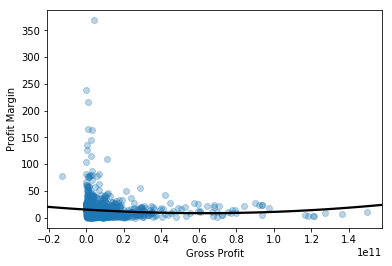

In [15]:
# Show non-linearity between variables.
sns.regplot(
    df['Gross Profit'],
    y=df['Profit Margin'],
    y_jitter=.49,
    order=2,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

In [16]:
# Create features based on squared variables.
features['profit_margin_squared'] = df['Profit Margin'] * df['Profit Margin']
features['cash_ratio_squared'] = df['Cash Ratio'] * df['Cash Ratio']

#### 6. Leveling the playing field.

Some modeling methods assume that all features have values in the same range (all features have a min of 0 and max of 1, for example). Features that vary in range can result in incorrect estimates. Variables can be normalized to the same scale, usually a mean of 0 and standard deviation of 1.

C:\Users\James\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


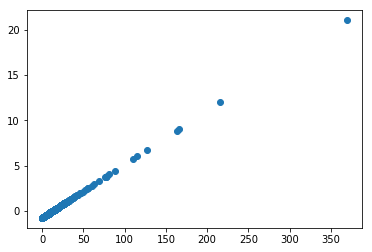

         Unnamed: 0  Accounts Payable  Accounts Receivable  \
count  1.299000e+03      1.299000e+03         1.299000e+03   
mean  -2.365741e-16      2.435824e-17        -8.053177e-17   
std    1.000385e+00      1.000385e+00         1.000385e+00   
min   -1.774262e+00     -4.876323e-01        -1.202930e+01   
25%   -8.269412e-01     -4.122634e-01        -5.158417e-02   
50%    6.149513e-03     -3.111351e-01         9.925660e-02   
75%    8.638588e-01     -6.013303e-02         1.711474e-01   
max    1.729446e+00      7.635306e+00         8.987810e+00   

       Add'l income/expense items  After Tax ROE  Capital Expenditures  \
count                1.299000e+03   1.299000e+03          1.299000e+03   
mean                -7.207048e-17  -5.720982e-18          4.230642e-17   
std                  1.000385e+00   1.000385e+00          1.000385e+00   
min                 -6.154415e+00  -1.890961e-01         -1.080434e+01   
25%                 -1.212111e-01  -1.450595e-01          2.145121e-02 

In [17]:
# Use scikit-learn preprocessing to normalize.
from sklearn import preprocessing

# Select only numeric variables to scale.
df_num = df.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)

# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['Profit Margin'], df_scaled['Profit Margin'])
plt.show()
print(df_scaled.describe())

#### 7. Creating interactions.

If the relationship between the outcome and a feature depends on the value of a second feature, a feature that represents the interaction can be created.

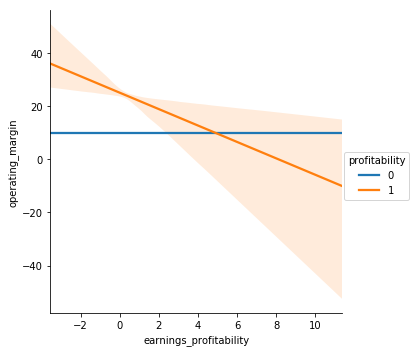

In [18]:
# Create a profitability feature and capture its interaction with the earnings feature that was created earlier. Store the interaction in a new feature.
features['profitability'] = np.where(df['Profit Margin'] >= 10, 1, 0)
features['earnings_profitability'] = features['earnings'] * features['profitability']

# Plot the new feature's interaction with a varibale from the dataset.
features['operating_margin'] = df['Operating Margin']
sns.lmplot(
    x='earnings_profitability',
    y='operating_margin',
    hue='profitability',
    data=features,
    scatter=False
)
plt.show()

### C. Principal Component Analysis

The overall goal of PCA is to reduce the number of d dimensions (features) in a dataset by projecting it onto a k dimensional subspace where k < d. PCA works best for normally-distributed data and assumes the relationships among variables are linear. PCA also works best when the variables involved range from weakly correlated to moderately strongly correlated. PCA consists of the following steps: 

#### 1. Standardize the data.

PCA can only be applied on numerical data. Standardize the data by removing non-numeric columns, transforming variables onto a unit scale (mean=0, variance=1), and converting all null values to 0.

In [19]:
# Drop non-numeric variables and rows with missing values.
df1 = df.drop(['Unnamed: 0', 'Period Ending'], axis=1).dropna()

# Extract label column (i.e., Ticker Symbol).
cols = df1.columns.tolist()
cols.insert(0, cols.pop(cols.index('Ticker Symbol')))
df1 = df1.reindex(columns= cols)
df2 = df1.iloc[:,1:].values
df3 = pd.DataFrame(data=df1.iloc[:,0].values)

# Standardize data using scikit-learn's StandardScaler.
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(df2)

#### 2. Generate a covariance matrix.

The covariance matrix is a representation of the covariance between each feature in the original dataset.

In [20]:
print(np.cov(X_std.T))

[[ 1.00077042 -0.20397547  0.31055163 ...,  0.14181629  0.5193928
   0.03284907]
 [-0.20397547  1.00077042 -0.0165555  ..., -0.09307728 -0.17485857
   0.02911951]
 [ 0.31055163 -0.0165555   1.00077042 ...,  0.09748752  0.18287878
  -0.01687119]
 ..., 
 [ 0.14181629 -0.09307728  0.09748752 ...,  1.00077042 -0.05189025
  -0.01358919]
 [ 0.5193928  -0.17485857  0.18287878 ..., -0.05189025  1.00077042
   0.00667264]
 [ 0.03284907  0.02911951 -0.01687119 ..., -0.01358919  0.00667264
   1.00077042]]


#### 3. Perform eigendecomposition. 

Obtain eigenvectors (principal components) and eigenvalues from the covariance matrix. Each eigenvector will have a corresponding eigenvalue, and the sum of the eigenvalues represents all of the variance within the entire dataset.

In [21]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ -1.61291489e-01  -1.44423261e-02   9.79138686e-02 ...,  -1.47736424e-04
   -1.07857570e-04  -2.74362992e-04]
 [  4.21710820e-02   8.63840633e-02   6.98069890e-02 ...,   5.24382994e-07
    2.71867356e-05   2.12923486e-06]
 [ -7.24697828e-02  -2.40430521e-02   1.02080542e-01 ...,  -1.01443996e-06
   -4.98615736e-05   1.55363423e-06]
 ..., 
 [ -2.86411607e-02  -1.65858822e-01   1.53013315e-01 ...,   3.50102648e-08
    2.50358551e-05  -5.90544150e-06]
 [ -1.45018622e-01  -4.37046427e-02  -1.58876617e-01 ...,  -1.31296515e-06
    1.91744096e-05   7.92094583e-07]
 [ -1.23773234e-03  -2.64549972e-02  -2.16383843e-02 ...,   9.81273703e-07
    1.09188308e-05  -2.77101062e-06]]

Eigenvalues 
[  2.74136357e+01   5.03341684e+00   4.80450517e+00   4.09169854e+00
   3.10137419e+00   2.69605876e+00   2.42872675e+00   2.11728637e+00
   1.97649583e+00   1.79859788e+00   1.64080749e+00   1.38818544e+00
   1.35220452e+00   1.21547435e+00   1.06508557e+00   1.00801180e+00
   9.81745409e-0

#### 4. Sort the eigenvalues in descending order.

The eigenvectors with the lowest eigenvalues describe the least amount of variation within the dataset. Therefore, these values can be dropped.

In [22]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
27.413635688
5.03341683895
4.80450517245
4.09169854216
3.10137418793
2.69605876125
2.42872674852
2.11728636672
1.9764958282
1.79859788049
1.64080748828
1.38818543573
1.35220452291
1.215474355
1.06508556665
1.0080117974
0.981745408885
0.951303766886
0.889018040268
0.854445693075
0.825948913381
0.766491872328
0.680011148239
0.661455767522
0.619072464743
0.570228805709
0.551397382581
0.499086200357
0.46058714569
0.438777357422
0.415489412832
0.358951715087
0.332454423637
0.311422434717
0.283381842253
0.252482106952
0.221188362473
0.209814028078
0.192149620745
0.189670449758
0.153850952677
0.149216707001
0.123480771541
0.119909090781
0.116748292265
0.103778431842
0.0914309057067
0.0824371334612
0.0758749115773
0.060683672024
0.0576430701475
0.04892923821
0.0477278543108
0.0384665003785
0.0317807368179
0.028194439794
0.0221804935742
0.0254079728778
0.0115011455338
0.00970321393391
0.00374774743301
0.00304426012059
0.00207772529357
0.00122506023075
0.00114259

#### 5. Select the k eigenvectors with the largest eigenvalues.

k eigenvectors represent the principal components that explain most of the variance in the dataset and, consequently, the number of dimensions that will be used in the new feature subspace. There are a number of rules that assist in choosing the number of components to keep; for example, eigenvalues greater than 1, or cutoffs above a certain variance. Ultimately, k is chosen based on the reasons for conducting the PCA.

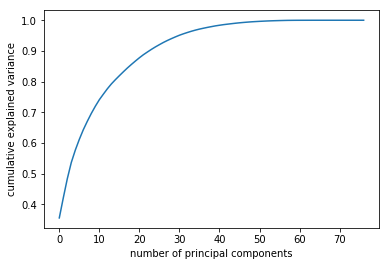

In [23]:
# Plot the cumulative explained variance (i.e., scree plot) using scikit-learn's PCA to determine how many principal components to choose for the new feature subspace.
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of principal components')
plt.ylabel('cumulative explained variance')
plt.show()

Assuming PCA requirements are at 90% cumulative variance, this corresponds to 22 principal components on the scree plot; therefore, pick the top 22 eigenvalues from step 4.

#### 6. Construct a new matrix with the selected k eigenvectors.

In [24]:
# Construct the projection matrix using the 22 principal components.
sklearn_pca = PCA(n_components=22)
Y_sklearn = sklearn_pca.fit_transform(X_std)
print(Y_sklearn,'\n')
print(Y_sklearn.shape)

[[-1.07329807 -1.76885367  0.42733352 ...,  0.78232484 -0.48185463
  -1.20095457]
 [ 0.10395133 -2.2196762   1.85639942 ...,  0.9761973  -0.39374863
  -1.1729901 ]
 [ 2.19594806 -1.36522161  0.13722148 ...,  0.17822213  0.13652905
  -1.52041328]
 ..., 
 [-1.85153116  0.16569087  0.51938153 ..., -0.58714341  0.68905689
   2.62022517]
 [-2.26082779  0.43851724  0.24343694 ..., -0.12696853  0.12891084
   0.14659143]
 [-2.04506005  0.20782788  0.03633819 ..., -0.13306176  0.45795253
   0.12849735]] 

(1299, 22)


The 77 variables from the original dataset were reduced to 22 principal components at 90% variance. Note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the main dimensions of variation.

In [25]:
# Construct the new dataframe with the principal components and label column (i.e., Ticker Symbol extracted from step 1).
df4 = pd.DataFrame(data = Y_sklearn, columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20','pc21','pc22'])
df5 = pd.concat([df3, df4], axis = 1)
df5.rename(columns={0: 'ticker_symbol'}, inplace=True)
df5.head()

,ticker_symbol,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22
0,AAL,-1.073298,-1.768854,0.427334,-1.817140,0.022881,-1.781807,0.749612,-0.664135,-0.505958,...,0.123355,0.109679,0.973789,-2.147420,-1.166285,-2.657731,-0.380266,0.782325,-0.481855,-1.200955
1,AAL,0.103951,-2.219676,1.856399,-2.464151,0.143499,-1.922095,1.262274,-0.155283,-0.658719,...,-0.684407,-0.158865,0.944773,-1.576027,-1.633920,-2.701987,-0.111555,0.976197,-0.393749,-1.172990
2,AAL,2.195948,-1.365222,0.137221,-1.042837,-0.259900,-1.023171,1.147905,-1.021228,0.569619,...,-0.157170,0.074288,0.589009,0.250355,-0.646092,-2.224325,0.057880,0.178222,0.136529,-1.520413
3,AAL,3.165962,-0.518329,0.084240,-0.940533,-0.384653,-0.724165,1.171010,-0.217962,1.035834,...,-0.646258,-1.330205,0.356157,1.151236,0.608983,-2.189841,0.277338,0.242855,1.871870,-1.133674
4,AAP,-2.302505,0.255084,-1.204769,-0.328916,-0.664806,-0.342176,-0.310922,0.436838,-0.196969,...,0.184366,0.496430,0.201183,-1.026586,0.175749,-0.489823,-0.247047,-0.209869,0.627320,0.592646
